In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

import pandas as pd

In [2]:
# Backend set up for neural networks
torch.cuda.empty_cache()
# Set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

# CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# General purpose PINN structure (treat this like an abstract class)

class PINN(nn.Module):
    def __init__(self, hidden_layers=[20,20,20,20], activation="relu"):
        super().__init__()
        self.input_layer = nn.Linear(2, hidden_layers[0])
        self.activation = self._get_activation(activation)
        self.hidden = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)])
        self.output = nn.Linear(hidden_layers[-1], 1)
        self.apply(self._initialize_weights)
    
    @staticmethod 
    def _get_activation(activation):
        if activation.lower() == "tanh":
            return nn.Tanh()
        elif activation.lower() == "relu":
            return nn.ReLU()
        else:
            return nn.ReLU()
        
    @staticmethod 
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x ,t):
        input = torch.cat([x,t], dim=1)
        output = self.input_layer(input)
        for layer in self.hidden:
            output = self.activation(layer(output))
        output = self.output(output)
        return output


In [4]:
class BurgersPINN(nn.Module):
    def __init__(self, hidden_layers=[40,40,40,40], activation="ReLU", nu=0.001):
        super().__init__()
        self.model = PINN(hidden_layers, activation)
        self.nu = nu
    
    def forward(self, x, t):
        return self.model(x, t)
    
    def burgers_residual(self, x, t, nu):
        # Changing viscosity matching the model's viscocity
        nu = self.nu
        # Create tensors that require gradients
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)

        # Forward pass
        u = self.model.forward(x,t)

        # Gradients
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True
        )[0]

        # Plug gradients into Burgers equation for residual
        return u_t + u * u_x - nu*u_xx

    """
    Analytical solution to initial of u(x,0) = -sin(pi * x) and zero spatial boundary
    """
    def analytical_solution_1(self, x,t):

        x_p = x.detach().cpu().numpy().flatten() if torch.is_tensor(x) else np.array(x).flatten()
        t_p = t.detach().cpu().numpy().flatten() if torch.is_tensor(t) else np.array(t).flatten()
        nu = self.nu
        u = np.zeros_like(x)

        def phi_0(x):   # Integral of -sin(pi * x) = cos(pi * x)/pi + C but set C = 0 for simplicity
            return np.exp(-1/(2*nu) * (-np.cos(np.pi*x) / np.pi))
        
        def heat_kernel(x,y,t):
            return np.exp(-(x - y)**2 / (4*nu*t)) / np.sqrt(4*np.pi*nu*t)
        
        def dx_heat_kernel(x,y,t):
            return (-(x-y))/(2*nu*t) * heat_kernel(x,y,t)
        
        # Solving the heat equation
        for i, (xi, ti) in enumerate(zip(x_p, t_p)):

            if ti == 0: # Initial condition
                u[i] = -np.sin(np.pi*xi)
            else:
                # Computing \phi(x,t)
                phi = integrate.quad(lambda y : heat_kernel(xi, y, ti) * phi_0(y), -1, 1)[0]

                # Computing \phi_x(x,t)
                phi_x = integrate.quad(lambda y : dx_heat_kernel(xi,y,ti) * phi_0(y), -1, 1)[0]

                # Cole-Hopf transformation
                u[i] = -2*nu* (phi_x/phi)

        return torch.tensor(u).reshape(-1,1)

In [5]:
def train(model, x_bounds, t_bounds, boundary_conditions, nu, epochs=5000, lr=0.001,
    collocation_points=2000, initial_points=2000, boundary_points=2000):
    # Setting up the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)

    # Getting the bounds
    x_min, x_max = x_bounds
    t_min, t_max = t_bounds

    # Training history
    history = {"total_loss": [], "residual_loss": [], "initial_loss": [], "boundary_loss": []}

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Sampling points
        x_colloctions = torch.rand(collocation_points, 1, device=device) * (x_max - x_min) + x_min
        t_collocations = torch.rand(collocation_points, 1, device=device) * (t_max - t_min) + t_min

        x_initial = torch.rand(initial_points, 1, device=device) * (x_max - x_min) + x_min
        t_initial = torch.zeros(initial_points, 1, device=device)

        x_boundary_left = torch.ones(boundary_points, 1, device=device) * x_min
        x_boundary_right = torch.ones(boundary_points, 1, device=device) * x_max
        t_boundary = torch.rand(boundary_points, 1, device=device) * (t_max - t_min) + t_min

        # Residual loss
        residual = model.burgers_residual(x_colloctions, t_collocations, nu)
        residual_loss = torch.mean(residual**2)

        # Initial condition loss
        ic_pred = model(x_initial, t_initial)
        ic_true = boundary_conditions["initial_condition"](x_initial)
        ic_loss = torch.mean((ic_pred - ic_true)**2)

        # Boundary loss
        boundary_left_pred = model(x_boundary_left, t_boundary)
        boundary_right_pred = model(x_boundary_right, t_boundary)
        boundary_left_true = boundary_conditions["boundary_left"](t_boundary)
        boundary_right_true = boundary_conditions["boundary_right"](t_boundary)
        boundary_loss = torch.mean((boundary_left_pred - boundary_left_true)**2) + torch.mean((boundary_right_pred - boundary_right_true)**2)

        # Combine the losses to the total loss
        loss = residual_loss + 10 * (ic_loss +  boundary_loss)

        # Backpropagate and update optimizer
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        # Append to loss history
        history["total_loss"].append(loss.item())
        history["residual_loss"].append(residual_loss.item())
        history["initial_loss"].append(ic_loss.item())
        history["boundary_loss"].append(boundary_loss.item())

        # Print with a predetermined interval
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, Residual Loss: {residual_loss.item():.6f}, Initial Loss: {ic_loss.item():.6f}, Boundary Loss: {boundary_loss.item():.6f}")
            
    return history

def plot(model, x_bounds, t_bounds, x_plot_pts, t_plot_pts, analytical_data_path):

    # Setting up mesh grids
    x_min, x_max = x_bounds
    t_min, t_max = t_bounds

    x = torch.linspace(x_min, x_max, x_plot_pts).reshape(-1, 1)
    t = torch.linspace(t_min, t_max, t_plot_pts).reshape(-1, 1)
    
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')

    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    # Predict solutions
    with torch.no_grad():
        U_pred = model(X_flat, T_flat).to("cpu")
    
    U_pred = U_pred.reshape(x_plot_pts, t_plot_pts)

    # Plotting the time-evolution as 3d graph
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot_surface(X.numpy(), T.numpy(), U_pred.numpy(), cmap="viridis")
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u(x,t)')
    ax1.set_title('PINN Solution')

    # Plotting time slices at specific t values
    ax2 = fig.add_subplot(222)
    t_slices = [0, 0.25, 0.5, 0.75, 1]
    colors = ['b', 'g', 'r', 'c', 'm']
    
    for t_val, color in zip(t_slices, colors):
        # Find the closest time index
        t_idx = np.argmin(np.abs(t.squeeze().numpy() - t_val))
        ax2.plot(x.squeeze().numpy(), U_pred[:, t_idx].numpy(), 
                color=color, label=f't = {t_val:.2f}')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('u(x,t)')
    ax2.set_title('Time Slices of PINN Solution')
    ax2.legend()

    # Plotting the analytical solution (with time-evolution)
    try:
        u_analytical = pd.read_csv(analytical_data_path, delimiter="  ", header=None, engine="python")
    except:
        print(f"Could not load exact solution:")
        
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.plot_surface(X.numpy(), T.numpy(), u_analytical, cmap="viridis")
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('u(x,t)')
    ax3.set_title("Analytical Solution")

    # Plot the difference with analytical solution
    error = np.abs(U_pred.numpy() - u_analytical)
    np.savetxt("error.csv", error, delimiter=',')

    ax4 = fig.add_subplot(224)
    fig.colorbar(ax4.pcolormesh(X.numpy(), T.numpy(), error, cmap="jet"))
    ax4.set_xlabel('x')
    ax4.set_ylabel('t')
    ax4.set_title(f"Point-wise error. Max: {np.max(error):.6f}")

    

    plt.tight_layout()
    plt.savefig('burgers_pinn_solution.png')
    plt.show()

    print(f"Mean Absolute error:  {np.mean(error):.6f}")

In [8]:
# Setting up boundary conditions
def initial_condition(x):
    return -torch.sin(np.pi * x)
    
def boundary_left(t):
    return torch.zeros_like(t)
    
def boundary_right(t):
        return torch.zeros_like(t)
    
boundary_conditions = {
    "initial_condition": initial_condition,
    "boundary_left": boundary_left,
    "boundary_right": boundary_right
}

# Setting up (square) domain
x_bounds = [-1,1]
t_bounds = [0,1]
nu = 0.001

# Initialize model
model = BurgersPINN(hidden_layers=[64,64,64,64,64], activation="tanh").to(device)

# Train model
history = train(
    model=model,
    x_bounds=x_bounds,
    t_bounds=t_bounds,
    nu=nu,
    boundary_conditions=boundary_conditions,
    collocation_points=5000,
    boundary_points=1000,
    initial_points=1000,
    epochs=3001,
    lr=0.001
)

Epoch 0, Total Loss: 4.675464, Residual Loss: 0.005834, Initial Loss: 0.350249, Boundary Loss: 0.116714
Epoch 500, Total Loss: 0.376237, Residual Loss: 0.295450, Initial Loss: 0.005601, Boundary Loss: 0.002478
Epoch 1000, Total Loss: 0.263134, Residual Loss: 0.216535, Initial Loss: 0.004370, Boundary Loss: 0.000290
Epoch 1500, Total Loss: 0.268356, Residual Loss: 0.222047, Initial Loss: 0.004431, Boundary Loss: 0.000200
Epoch 2000, Total Loss: 0.264165, Residual Loss: 0.214634, Initial Loss: 0.004717, Boundary Loss: 0.000236
Epoch 2500, Total Loss: 0.264764, Residual Loss: 0.218672, Initial Loss: 0.004394, Boundary Loss: 0.000216
Epoch 3000, Total Loss: 0.267457, Residual Loss: 0.220612, Initial Loss: 0.004451, Boundary Loss: 0.000234


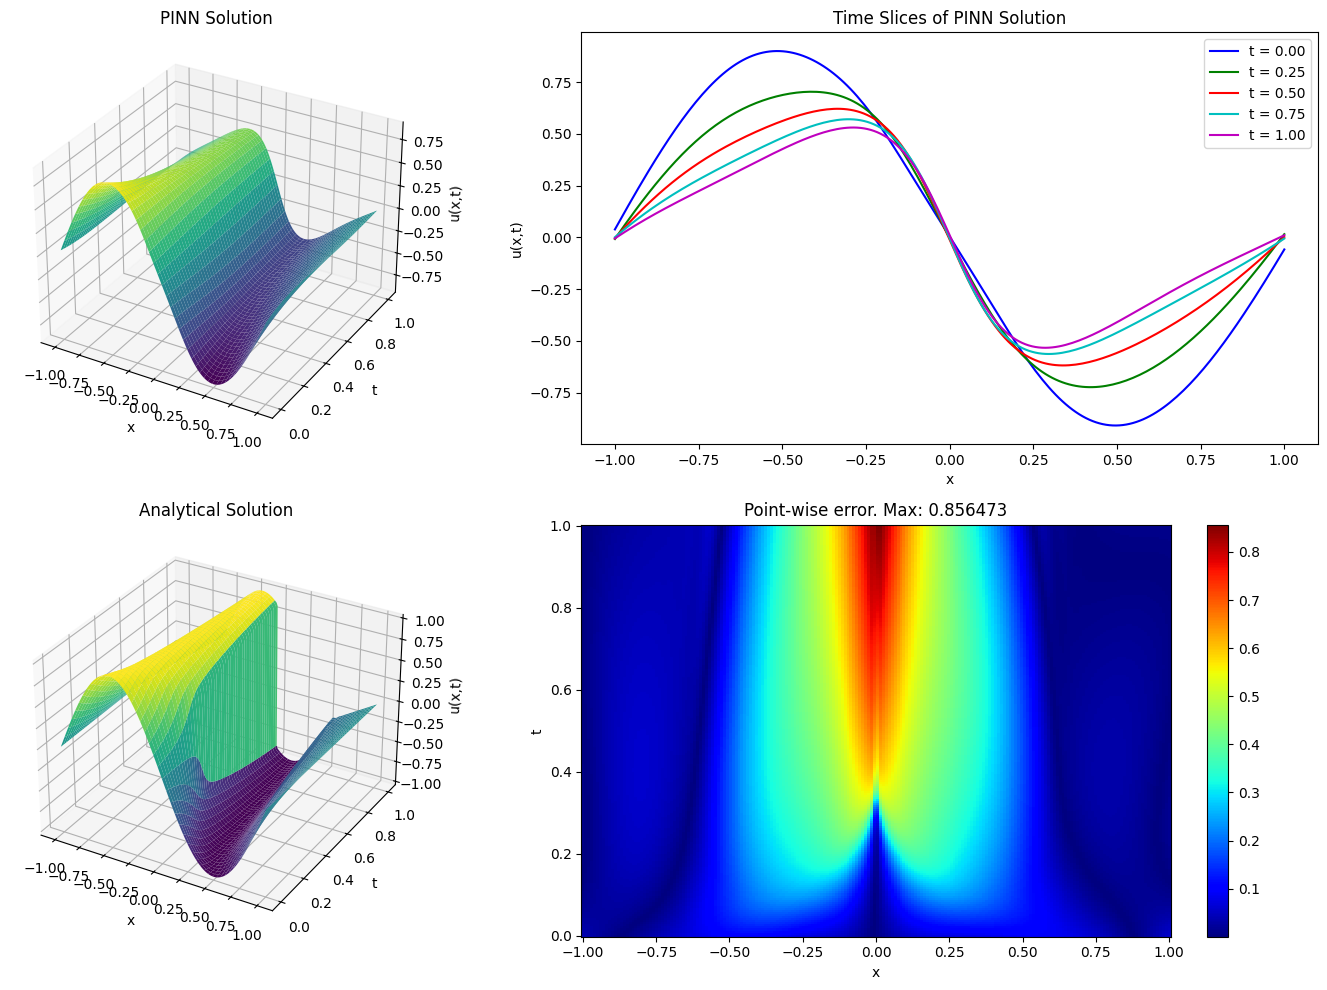

Mean Absolute error:  0.199546


In [9]:
model.to("cpu")
plot(model=model, x_bounds=x_bounds, t_bounds=t_bounds, x_plot_pts=200, t_plot_pts=200, analytical_data_path="burgers-analytical/burgers_solution_200_200.txt")